## General

In [5]:
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
)
from brainlit.utils.Neuron_trace import NeuronTrace

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import splev, splprep, RegularGridInterpolator
from scipy.spatial.distance import cosine
from scipy.stats import wilcoxon, pearsonr, linregress, norm
from tqdm import tqdm
from cloudvolume import CloudVolume
from similaritymeasures import frechet_dist
import seaborn as sns
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
from cloudvolume.exceptions import SkeletonDecodeError
import pickle
from copy import deepcopy
import networkx as nx
import os
from skimage import io
from matplotlib import cm
from matplotlib.colors import ListedColormap
from turtle import color
from scipy.ndimage import distance_transform_edt, binary_dilation
from joblib import Parallel, delayed

### Initialize objects

In [5]:
root_dir = Path(os.path.abspath(""))
data_dir = os.path.join(root_dir, "data", "mapping-files")

velocity_path = os.path.join(data_dir, "downloop_1_v.mat")
affine_path = os.path.join(data_dir, "downloop_1_A.mat")

ct = CloudReg_Transform(velocity_path, affine_path, direction="atlas")

ara = io.imread("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif")

og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

print(f"x {xmax-xmin} y{ymax-ymin}-{ymax} z{zmax-zmin}")

integrating velocity field: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


x 13300.0 y15100.0-7550.0 z9900.0


Range of og_coords has padding of 190microns in total

### Functions for plotting

In [6]:
def get_transformed_line(a, b, ct):
    ts = np.arange(0, 1.01, 0.01)
    line = np.zeros((len(ts), len(a)))
    for i, t in enumerate(ts):
        line[i, :] = a + t * (b - a)
    new_line = ct.evaluate(line)
    return new_line


def get_displacements(xs, ys, zs, ct):
    og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
    og_coords = np.array(
        [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
    ).T
    print(f"shp: {og_coords.shape}")
    new_coords = ct.evaluate(og_coords)
    diff = new_coords - og_coords

    return og_coords, diff


def get_border(im, border_id=0):
    if (im < 0).any():
        raise ValueError(f"Input image cannot have negative values")
    if border_id != 0:
        im[im == 0] = -1
        im[im == border_id] = 0
    edt = distance_transform_edt(im)
    edt[edt != 1] = 0
    return edt

## Plot displacement field over atlas

shp: (160, 3)
(1320, 800)


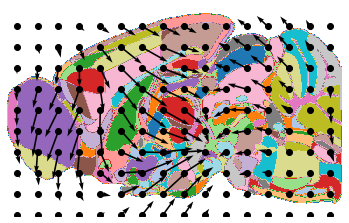

In [4]:
slice_num = 600


fig, ax = plt.subplots()

xs = np.array([slice_num * 10 + 95])
ys = np.arange(ymin, ymax, 1000)
zs = np.arange(zmin, zmax, 1000)

og_coords, diff = get_displacements(xs, ys, zs, ct)

for y in ys:
    a = np.array([xs[0], y, zmin])
    b = np.array([xs[0], y, zmax])
    new_line = get_transformed_line(a, b, ct)
    # ax.plot(new_line[:,1], new_line[:,2], c='white')

for z in zs:
    a = np.array([xs[0], ymin, z])
    b = np.array([xs[0], ymax, z])
    new_line = get_transformed_line(a, b, ct)
    # ax.plot(new_line[:,1], new_line[:,2], c='white')

ax.scatter(og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid", c="black")


ax.quiver(
    og_coords[:, 1],
    og_coords[:, 2],
    diff[:, 1],
    diff[:, 2],
    label="Scaled Displacement Field",
    color="black",
)
ax.axis("off")

# ARA slice

ara_slice = np.squeeze(ara[:, :, slice_num])
unqs = np.unique(ara_slice)


for i, unq in enumerate(unqs):
    if unq != 0:
        ara_slice[ara_slice == unq] = i
print(ara_slice.shape)

cmap = cm.get_cmap("tab20")
newcolors = cmap(np.arange(20))
newcolors = np.repeat(newcolors, 10, 0)
white = np.array([1, 1, 1, 1])
newcolors[0, :] = white
newcmp = ListedColormap(newcolors)
ax.imshow(ara_slice.T, extent=(-8000, 8000, -5000, 5000), cmap=newcmp)

## Plot Jacobian over atlas border

100%|██████████| 10201/10201 [01:17<00:00, 132.11it/s]


(101, 1, 101)
shp: (81, 3)


Text(0.5, 0.98, 'Log Jacobian Determinant of Atlas to Target Mapping')

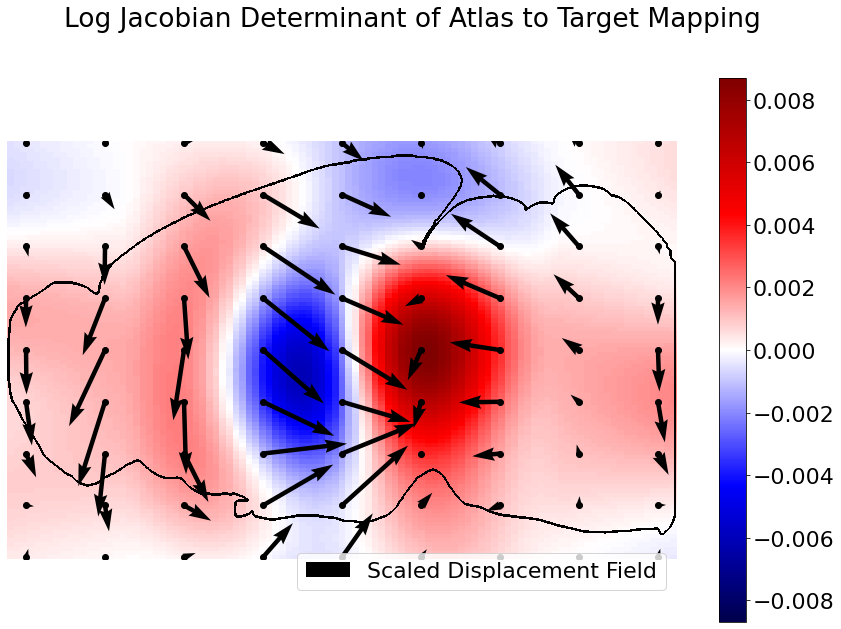

In [5]:
z = 600
plt.rcParams.update({"font.size": 22})


fig, ax = plt.subplots(figsize=(15, 10))


# Determinant jacobians
xs = np.array([z * 10 + 95])
ys = np.arange(ymin, ymax + 1, (ymax - ymin) / 100)
zs = np.arange(zmin, zmax + 1, (zmax - zmin) / 100)


Xs, Ys, Zs = np.meshgrid(xs, ys, zs)
XYZs = np.reshape(np.stack((Ys, Xs, Zs), axis=-1), newshape=(-1, 3))
detJs = []

for coord in tqdm(XYZs):
    J = ct.Jacobian(coord)
    detJs.append(np.log(np.linalg.det(J)))

detJs = np.array(detJs)
detJs = np.reshape(detJs, newshape=Xs.shape)
print(detJs.shape)


newcolors = np.array([[1, 1, 1, 0], [0, 0, 0, 1]])
cmap_trans_white = ListedColormap(newcolors)

max_abs = np.amax(np.abs(detJs))
plt_ldjs = ax.imshow(
    np.squeeze(detJs).T,
    extent=(-8000, 8000, -5000, 5000),
    cmap="seismic",
    vmin=-max_abs,
    vmax=max_abs,
)
ax.axis("off")
fig.colorbar(plt_ldjs, ax=ax)

# Displacement

xs = np.array([z * 10 + 95])
ys = np.arange(ymin, ymax + 1, (ymax - ymin) / 8)
zs = np.arange(zmin, zmax + 1, (zmax - zmin) / 8)
og_coords, diff = get_displacements(xs, ys, zs, ct)

ax.scatter(og_coords[:, 1], og_coords[:, 2], c="black")


ax.quiver(
    og_coords[:, 1],
    og_coords[:, 2],
    diff[:, 1],
    diff[:, 2],
    label="Scaled Displacement Field",
    color="black",
)


# ARA border

ara_slice = np.squeeze(ara[:, :, z])
border = get_border(ara_slice)
border = border.T
border = binary_dilation(border, iterations=2)
plt_border = ax.imshow(border, extent=(-8000, 8000, -5000, 5000), cmap=cmap_trans_white)

ax.legend(loc="lower right", bbox_to_anchor=(1, -0.1))
fig.suptitle("Log Jacobian Determinant of Atlas to Target Mapping")

## Find max jacobian

In [1]:
import multiprocessing

multiprocessing.cpu_count()

12

In [7]:
# Determinant jacobians
grid = "cust-full"
xmin, xmax = -1890, -250
ymin, ymax = -2400, -1600
zmin, zmax = 800, 2000
if grid == "cust-full":
    xs = np.arange(xmin, xmax + 1, (xmax - xmin) / 50)
    ys = np.arange(ymin, ymax + 1, (ymax - ymin) / 50)
    zs = np.arange(zmin, zmax + 1, (zmax - zmin) / 50)
    Xs, Ys, Zs = np.meshgrid(xs, ys, zs)
elif grid == "full":
    Xs, Ys, Zs = og_coords[0], og_coords[1], og_coords[2]
elif grid == "cust-box":
    xmin, xmax = -1950, -250
    ymin, ymax = -2450, -1650
    zmin, zmax = 750, 1950
    xs = np.arange(xmin, xmax + 1, (xmax - xmin) / 50)
    ys = np.arange(ymin, ymax + 1, (ymax - ymin) / 50)
    zs = np.arange(zmin, zmax + 1, (zmax - zmin) / 50)
    Xs, Ys, Zs = np.meshgrid(xs, ys, zs)

XYZs = np.reshape(np.stack((Ys, Xs, Zs), axis=-1), newshape=(-1, 3))
norms = []


def norm_diff(coord):
    diff = ct.Jacobian(coord) - np.eye(3)

    return np.linalg.norm(diff)


norms = Parallel(n_jobs=10)(delayed(norm_diff)(coord) for coord in tqdm(XYZs))


max_abs = np.amax(norms)

rad = np.linalg.norm([xmax - xmin - 190, ymax - ymin - 190, zmax - zmin - 190])
print(f"Max |J-I|: {max_abs}, rad {rad} = {rad*max_abs}")

100%|██████████| 132651/132651 [06:05<00:00, 362.78it/s]


Max |J-I|: 0.0215624756966549, rad 1869.4116721578475 = 40.309143747946585


In [8]:
def displacement(coord):
    diff = ct.evaluate(coord) - coord

    return np.linalg.norm(diff)


displacements = Parallel(n_jobs=10)(delayed(norm_diff)(coord) for coord in tqdm(XYZs))

max_displacement = np.amax(displacements)
print(f"Max |ei-ei-1|: {2*max_displacement}")

100%|██████████| 132651/132651 [05:54<00:00, 374.00it/s]


Max |ei-ei-1|: 0.0431249513933098


Bound: Zeroth Order Mapping Error <= 0.01078123784832745L + 0.0215624756966549 


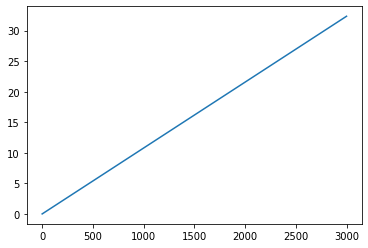

In [13]:
xs = np.arange(0, 3000)
ys = max_abs * xs / 2 + max_displacement

print(f"Bound: Zeroth Order Mapping Error <= {max_abs/2}L + {max_displacement} ")

plt.plot(xs, ys)

## Spectral norms of jacobians

In [12]:
# spectral norm jacobians
xs = np.arange(xmin, xmax + 1, (xmax - xmin) / 25)
ys = np.arange(ymin, ymax + 1, (ymax - ymin) / 25)
zs = np.arange(zmin, zmax + 1, (zmax - zmin) / 25)


Xs, Ys, Zs = np.meshgrid(xs, ys, zs)
XYZs = np.reshape(np.stack((Ys, Xs, Zs), axis=-1), newshape=(-1, 3))
normJs = []

for coord in tqdm(XYZs):
    J = ct.Jacobian(coord)
    normJs.append(np.linalg.norm(J))

100%|██████████| 17576/17576 [01:58<00:00, 148.41it/s]


(array([   31.,    69.,   111.,   180.,   508.,  3720., 10763.,  1715.,
          341.,   138.]),
 array([1.71923854, 1.72126283, 1.72328712, 1.72531141, 1.7273357 ,
        1.72935998, 1.73138427, 1.73340856, 1.73543285, 1.73745714,
        1.73948142]),
 <BarContainer object of 10 artists>)

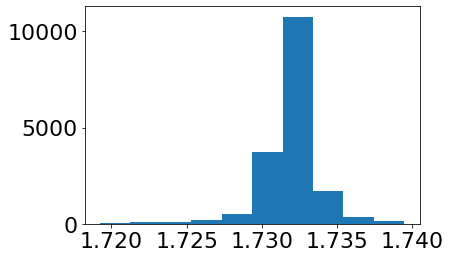

In [13]:
plt.hist(normJs)

100%|██████████| 121/121 [00:00<00:00, 10245.71it/s]

(11, 1, 11)
shp: (121, 3)


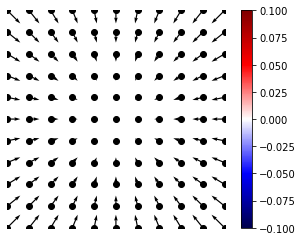

In [16]:
def Fx(pos):
    pos = np.array(pos)
    if len(pos.shape) == 1:
        return pos[0]
    elif len(pos.shape) == 2:
        return pos[:, 0]


def Fy(pos):
    pos = np.array(pos)
    if len(pos.shape) == 1:
        return pos[1]
    elif len(pos.shape) == 2:
        return pos[:, 1]


def Fz(pos):
    pos = np.array(pos)
    if len(pos.shape) == 1:
        return pos[2]
    elif len(pos.shape) == 2:
        return pos[:, 2]


og_diffeo = ct.diffeomorphism
ct.diffeomorphism = (Fx, Fy, Fz)


fig, ax = plt.subplots()


# Determinant jacobians
xs = np.array([0])
ys = np.arange(-5, 6)
zs = np.arange(-5, 6)


Xs, Ys, Zs = np.meshgrid(xs, ys, zs)
XYZs = np.reshape(np.stack((Ys, Xs, Zs), axis=-1), newshape=(-1, 3))
detJs = []

for coord in tqdm(XYZs):
    J = ct.Jacobian(coord)
    detJs.append(np.log(np.linalg.det(J)))

detJs = np.array(detJs)
detJs = np.reshape(detJs, newshape=Xs.shape)
print(detJs.shape)


newcolors = np.array([[1, 1, 1, 0], [0, 0, 0, 1]])
cmap_trans_white = ListedColormap(newcolors)

max_abs = np.amax(np.abs(detJs))
plt_ldjs = ax.imshow(
    np.squeeze(detJs).T,
    extent=(-5, 5, -5, 5),
    cmap="seismic",
    vmin=-max_abs,
    vmax=max_abs,
)
ax.axis("off")
fig.colorbar(plt_ldjs, ax=ax)

# Displacement
og_coords, diff = get_displacements(xs, ys, zs, ct)

ax.scatter(og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid", c="black")


ax.quiver(
    og_coords[:, 1],
    og_coords[:, 2],
    diff[:, 1],
    diff[:, 2],
    label="Scaled Displacement Field",
    color="black",
)


ct.diffeomorphism = og_diffeo

## What is registration

In [40]:
vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_25um/average_25um"
)
im_og = np.array(vol[:, :, :])

Downloading: 100%|██████████| 58/58 [00:02<00:00, 19.85it/s]


(528, 320, 456, 1)


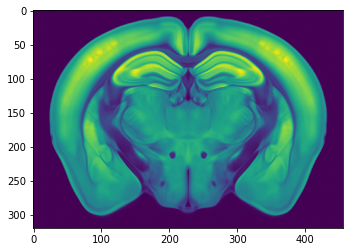

In [42]:
d = np.arange(im_og.shape[0])
v = np.arange(im_og.shape[1])
h = np.arange(im_og.shape[2])

image_interp = RegularGridInterpolator(
    (d, v, h), im_og, bounds_error=False, fill_value=0
)

plt.imshow(im_og[280, :, :])
print(im_og.shape)

In [230]:
# x is vertical component, y is horizontal
def deformation(h_atlas, v_atlas):
    y_disp = np.exp(-1 * v_atlas / 200) * np.exp(-1 * (h_atlas - 228) ** 2 / 10000) * 100
    return y_disp

k = 70
c2 = 0.01
m = 228
c1 = 0.0005
def deformation(h_atlas, v_atlas):
    v_target = v_atlas + k/(c2*v_atlas+c1*(h_atlas-m)**2+1)
    return v_target - v_atlas


def deform_inv(h_target,v_target):
    h_atlas = h_target
    c_combine = 1 + c1*(h_atlas-m)**2
    b = c_combine-v_target*c2
    c = k - v_target*c_combine
    a = c2
    disc = b**2-4*a*c
    v_atlas = (-b+np.sqrt(disc))/(2*a)

    return v_target - v_atlas


k=50
f = 1/50
def deformation(h_atlas, v_atlas):
    v_target = v_atlas + k*np.sin(f*h_atlas)*np.exp(-(h_atlas-300)**2/20000)
    return v_target - v_atlas


def deform_inv(h_target,v_target):
    h_atlas = h_target
    v_atlas = v_target - k*np.sin(f*h_atlas)*np.exp(-(h_atlas-300)**2/20000)

    return v_target - v_atlas

print(deformation(228, 0))
deform_inv(228, 0+deformation(228, 0))

-38.136300001326454


-38.136300001326454

<matplotlib.quiver.Quiver object at 0x15d933730>

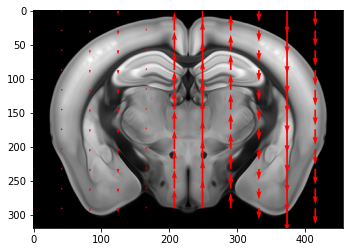

In [231]:
v_mat, h_mat = np.meshgrid(np.arange(0, im_og.shape[1], im_og.shape[1]/11), np.arange(0, im_og.shape[2], im_og.shape[2]/11))
v_flat = np.reshape(v_mat, (-1, 1))
h_flat = np.reshape(h_mat, (-1, 1))
y_displacements = deformation(h_flat, v_flat)
y_displacements = np.reshape(y_displacements, v_mat.shape)

plt.imshow(im_og[280, :, :], cmap="gray")
plt.quiver(
    h_mat,
    v_mat,
    0*y_displacements,
    -y_displacements,
    scale=1,
    scale_units="x",
    facecolor="red",
)

In [232]:
v_mat, h_mat, d_mat = np.meshgrid(v, h, d)

print(v_mat.shape)
v_flat = np.reshape(v_mat, (-1))
h_flat = np.reshape(h_mat, (-1))
d_flat = np.reshape(d_mat, (-1))

v_displacements = deformation(h_flat, v_flat)
new_v = v_flat - v_displacements

(456, 320, 528)


<matplotlib.image.AxesImage object at 0x15da92910>

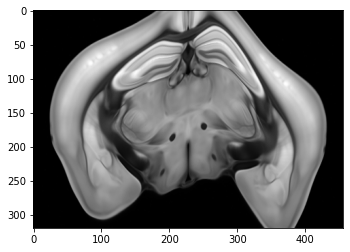

In [233]:
points = np.stack([d_flat, new_v, h_flat], axis=1)
new_im_flat = image_interp(points)
new_im = np.reshape(new_im_flat, v_mat.shape)
new_im = np.swapaxes(new_im, 0, -1)
new_im = new_im.astype("uint16")
plt.imshow(new_im[280, :, :], cmap="gray")

(144, 1)


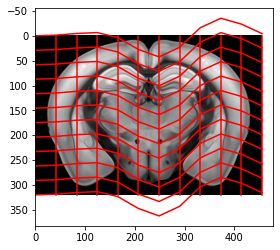

In [234]:
v_mat, h_mat = np.meshgrid(np.arange(0, im_og.shape[1]+1, im_og.shape[1]/11), np.arange(0, im_og.shape[2]+1, im_og.shape[2]/11))
v_flat = np.reshape(v_mat, (-1, 1))
h_flat = np.reshape(h_mat, (-1, 1))
y_displacements = deform_inv(h_flat, v_flat)
y_displacements = np.reshape(y_displacements, v_mat.shape)

print(v_flat.shape)


plt.imshow(im_og[280, :, :], cmap="gray")
for row in np.arange(y_displacements.shape[0]):
    xs = h_mat[:,row]
    ys = v_mat[:,row] - y_displacements[:,row]
    plt.plot(xs,ys, c='red')
for col in np.arange(y_displacements.shape[0]):
    xs = h_mat[col,:]
    ys = v_mat[col,:]
    plt.plot(xs,ys, c='red')